# Nerual Network for Classifying fine-grained images

In [13]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import os
from libcpab.libcpab.pytorch import cpab
from libcpab.libcpab.helper.utility import show_images
from IPython.display import display
import random

# Contruct dataframe with labels

In [4]:
### Contruct dataframe
def get_dataframe(csv_path=None):
    """
    Construct dataframe.
    
    Args
        csv_path: Path to csv file.
    """
    # construct dataframe with onehot notation
    df = pd.get_dummies(pd.read_csv("./data/dataset_v2/train.csv"))
    # create ID column with image file names
    df['id'] = df['image_id'].apply(lambda x: str(x)) + "_" + df['tag_id'].apply(lambda x: str(x)) + ".png"
    # set ID column to index in dataframe
    df = df.set_index(keys='id')
    # only use class columns
    df = df.iloc[:, 10:]

    return df

,sunroof,luggage_carrier,open_cargo_area,enclosed_cab,spare_wheel,wrecked,flatbed,ladder,enclosed_box,soft_shell_box,...,sub_class_truck,sub_class_van,color_black,color_blue,color_green,color_other,color_red,color_silver/grey,color_white,color_yellow
id,,,,,,,,,,,,,,,,,,,,,
16490_15036.png,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
16490_31658.png,-1,-1,0,-1,-1,0,-1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
17122_26971.png,0,0,0,0,0,0,-1,-1,-1,-1,...,0,0,0,0,0,0,1,0,0,0
12193_19301.png,0,0,0,0,0,0,-1,-1,-1,-1,...,0,0,0,0,0,0,0,1,0,0
12193_35906.png,-1,-1,0,-1,-1,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
# run test of dataframe contruction function
# define path to csv file

path = "./data/dataset_v2/train.csv"
df = get_dataframe(csv_path=path)
df.head()

# Add augmented samples to dataframe

In [5]:
def dfWithAugmented(df, path, search_string='aug'):
    """
    Append data to a dataframe where appended data gets its values from
    a row in the dataframe. 
    Designed for appending augmented data to original dataframe.
    
    Args
        df: Pandas dataframe which data is to be appended to.
        path: Path to directory where files are to be found.
        search_string: A string criteria for searching for files in directory.
    """
    # get filenames for augmented images
    filenames = [name for name in os.listdir(path) if os.path.isfile(path+name) and search_string in name]
    
    # construct temporary dataframe for data to append
    df_append = pd.DataFrame(data=[name for name in filenames], columns=['id']).set_index(keys='id')
    
    # iterate over all row indexes in dataframe to append
    for i in df_append.index:
        # get original target values for original image for augmented image
        values = df.iloc[list(np.where(df.index == i.replace('aug_', ''))[0])].values
        
        # iterate over columns and corresponding values in dataframe to append to
        for column, value in zip(range(len(df.columns)), values[0]):
            df_append[f"{df.columns[column]}"] = value
    
    df_new = pd.concat([df, df_append])
    
    return df_new

In [6]:
# run a test to extend the dataframe with augmented image files
# define the path to the augmented image files

path = './data/dataset_v2/training_imagery/cropped/'
df_aug = dfWithAugmented(df=df, path=path, search_string='16490_15036.png')
df_aug.loc['16490_15036.png']

,sunroof,luggage_carrier,open_cargo_area,enclosed_cab,spare_wheel,wrecked,flatbed,ladder,enclosed_box,soft_shell_box,...,sub_class_truck,sub_class_van,color_black,color_blue,color_green,color_other,color_red,color_silver/grey,color_white,color_yellow
id,,,,,,,,,,,,,,,,,,,,,
16490_15036.png,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
16490_15036.png,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# Calculate number of times to augment images w.r.t. class sizes

In [7]:
def calculateAugmentation(df, criteria=1000, restriction=10):
    """
    Calculate how many times a sample is to be upsampled with augmentation
    compared to the represantation of the classes.
    
    Be aware of samples of a low represented class can be part of a larger class also.
    The aforementioned can result in upsampling of high represented classes as well,
    when upsampling low represented classes.
    
    Args
        df: A dataframe which the upsampling size is calculated from.
            The indexes should be the ID's of the samples.
        criteria: The criteria to match number of times to upsample a class with.
    """
    # placeholders
    classes = {}
    samplesToAugment = {}
    
    # get number of occurrences for each class
    for column in df.columns:
        num_occ = len(df.loc[df[column] == 1])
        classes[column] = num_occ
    
    # sort classes by ascending size
    classes_sorted = sorted(classes.items(), key=lambda value: value[1])
    
    # iterate over classes and calculate
    # number of times to augment data to
    # match specified criteria
    for cls in classes_sorted:
        # get indexes for samples where class value is 1
        indexesInClass = df.loc[df[cls[0]] == 1].index

        # remove indexes that already are appended to samplesToAugment
        indexesToAugment = [indexesInClass[i] for i in range(len(indexesInClass)) \
                            if indexesInClass[i] not in samplesToAugment.keys()]
        
        # find how many times already is upsampled
        already_size = sum([samplesToAugment.get(sample) for sample in indexesInClass \
                            if sample in samplesToAugment.keys() and sample not in indexesToAugment])
        
        # calculate number of times samples in class 
        # should be upsampled to match specified criteria
        if len(indexesToAugment) == 0:
            augment_size = int(1000 - already_size)
        # split upsample size over all samples to augment
        else:
            augment_size = int((1000-already_size) / len(indexesToAugment))

        # respect restriction criteria
        if augment_size > restriction:
            augment_size = 10
        # if class is already upsampled enough
        # do not upsample remaining samples in class
        elif augment_size < 0:
            augment_size = 0
        
        # save indexes to augment and corresponding number of times to upsample
        for index in indexesToAugment:
            if index in samplesToAugment.keys():
                print("Index already in samplesToAugment, overwriting key..")
            samplesToAugment[index] = augment_size
        
    return samplesToAugment

In [8]:
# run test to calculate upsampling sizes for samples

samples = calculateAugmentation(df)
samples

{'12599_23360.png': 10,
 '19725_11495.png': 10,
 '13748_23885.png': 10,
 '13748_20345.png': 10,
 '16917_16874.png': 10,
 '18420_13560.png': 10,
 '15320_11975.png': 10,
 '18860_23851.png': 10,
 '19725_24690.png': 10,
 '19531_26689.png': 10,
 '19446_20689.png': 10,
 '18909_25161.png': 10,
 '10334_29722.png': 10,
 '13124_39776.png': 10,
 '12670_37409.png': 10,
 '12961_19113.png': 10,
 '16441_24786.png': 10,
 '13580_25036.png': 10,
 '11772_10365.png': 10,
 '12695_30508.png': 10,
 '19361_37590.png': 10,
 '15562_25057.png': 10,
 '10680_20188.png': 10,
 '15119_19143.png': 10,
 '17266_24390.png': 10,
 '12446_17654.png': 10,
 '13124_37427.png': 10,
 '10056_19427.png': 10,
 '15561_19177.png': 10,
 '19176_29875.png': 10,
 '11772_25824.png': 10,
 '12084_32518.png': 10,
 '13643_23381.png': 10,
 '13643_25913.png': 10,
 '13643_39406.png': 10,
 '11854_10917.png': 10,
 '11854_27895.png': 10,
 '18746_39118.png': 10,
 '18746_29147.png': 10,
 '11420_18695.png': 10,
 '11420_19004.png': 10,
 '13305_32564.pn

# Augmentation of images

In [9]:
def upsample(path=None, samples=None, DIM=224, optimize=False, N_fixed=None, N_opt=2, show_result=False):
    """
    Upsample images with CPAB augmentation technique.
    Augmented images are saved in same directory as original images.
        
        Args
            path: Path to directory with images.
            samples: Dictionary with ID's and corresponding upsampling size. Ex: {'ID_1': 10}
            DIM: Dimension of agumented images. (integer as H x W are the same)
            optimize: If true the augmentation is optimized with the Adam optimizer,
                      and the learned estimation of the transformed data is returned
                      instead of a first transdormation. 
                      Returns only a single augmented sample, default false.
            N_fixed: Number of augmented samples to return, should be give in samples dict {'sample_id': N}.
            N_opt: Number of times optimization procedure should be run, default 2.
            show_result: If true transformed images are presented, default false.
    """
    
    if not path:
        print("Please specify path to directory with samples.")
        return 0
        
    if not samples:
        print("No dictionary with sample ID's and sample size given.")
        return 0
    
    # convert images from PNG to JPG
    for sample in samples:
        # number of times sample should be upsampled
        N = samples.get(sample)
        if N_fixed != None:
            N = N_fixed
        
        # read image and convert from RGBA to RGB
        im = Image.open(path+sample)
        
        # convert images from RGBA to RGB
        if im.mode == "RGBA":
            im.load() # required for im.split()
            newIm = Image.new("RGB", im.size, color=(0, 0, 0)) # black - RGB(0,0,0) - background color
            newIm.paste(im, mask=im.split()[3]) # 3 is the alpha channel
            newIm.save(path+sample, "PNG", quality=80) # save image with old file ending name
        else:
            pass
        
        # augment images by estimation of the transformed data
        if optimize:
            for n in range(N):
                # read image again as RGB with 3 channels and normalize between [0, 1]
                data = plt.imread(path+sample, format="RGB") / 255
                data = np.expand_dims(data, 0) # create batch of data
                # Convert to torch tensor and torch format [n_batch, n_channels, width, height]
                data = torch.Tensor(data).permute(0,3,1,2)

                # Define transformer class
                T1 = cpab(tess_size=[3,3], device='cpu')

                # Sample random transformation
                theta_true = 0.5*T1.sample_transformation(1)

                # Transform the images
                transformed_data = T1.transform_data(data, theta_true, outsize=(DIM,DIM))
                
                # define a PyTorch procedure that enables estimation of the transformation
                T2 = cpab(tess_size=[3,3], device='cpu')
                theta_est = T2.identity(1, epsilon=1e-4)
                theta_est.requires_grad = True

                # PyTorch optimizer for estimation procedure
                optimizer = torch.optim.Adam([theta_est], lr=0.1)

                # Optimization loop
                max_opt = N_opt
                for i in range(max_opt):
                    trans_est = T2.transform_data(data, theta_est, outsize=(DIM, DIM))
                    loss = (transformed_data.to(trans_est.device) - trans_est).pow(2).mean()
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if show_result:
                    plt.subplots(1,3, figsize=(10, 15))
                    plt.subplot(1,3,1)
                    plt.imshow(data.permute(0,2,3,1).numpy()[0])
                    plt.axis('off')
                    plt.title('Source')
                    plt.subplot(1,3,2)
                    plt.imshow(transformed_data.permute(0,2,3,1).cpu().numpy()[0])
                    plt.axis('off')
                    plt.title('Target')
                    plt.subplot(1,3,3)
                    plt.imshow(trans_est.permute(0,2,3,1).cpu().detach().numpy()[0])
                    plt.axis('off')
                    plt.title('Estimate')
                    plt.show()

                # Get the corresponding numpy arrays in correct format [n_batch, width, height, n_channels]
                transformed_data = trans_est.permute(0, 2, 3, 1).cpu().detach().numpy()[0]

                # save augmented versions
                # name of image: aug[x]_[original_name] where x is in the interval [0,N]
                im = transformed_data * 255 # normalize pixel values between [0,255]
                filename = "aug"+str(n)+"_"+sample
                image = Image.fromarray(im.astype('uint8'), mode="RGB")
                image.save(os.path.join(path, filename)) # save in class folder
        
        # augment images without transformation optimization
        else:
            # read image again as RGB with 3 channels and normalize between [0, 1]
            data = plt.imread(path+sample, format="RGB") / 255
            data = np.tile(np.expand_dims(data, 0), [N,1,1,1]) # create batch of data
            # Convert to torch tensor and torch format [n_batch, n_channels, width, height]
            data = torch.Tensor(data).permute(0,3,1,2)

            # Define transformer class
            T1 = cpab(tess_size=[3,3], device='cpu')

            # Sample random transformation
            theta_true = 0.5*T1.sample_transformation(N)

            # Transform the images
            transformed_data = T1.transform_data(data, theta_true, outsize=(DIM,DIM))
            
            # Get the corresponding numpy arrays in correct format [n_batch, width, height, n_channels]
            transformed_data = transformed_data.permute(0, 2, 3, 1).cpu().numpy()
            
            if show_result:
                show_images(transformed_data)
            
            # save augmented versions
            # name of image: aug[x]_[original_name] where x is in the interval [0,N]
            n = 0
            for data_sample in transformed_data:
                im = data_sample * 255 # normalize pixel values between [0,255]
                filename = "aug"+str(n)+"_"+sample
                image = Image.fromarray(im.astype('uint8'), mode="RGB")
                image.save(os.path.join(path, filename)) # save in class folder
                n += 1
    return

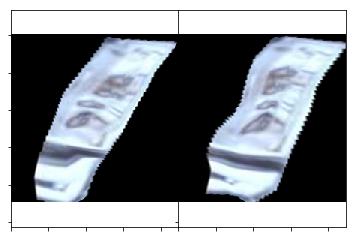

In [10]:
# Run a test for the upsampling function
# define path to images to upsample

path = './data/dataset_v2/training_imagery/test/'
test = {}
for sample in samples:
    test[sample] = samples[sample]
    break
    
upsample(path=path, samples=test, optimize=False, N_fixed=2, N_opt=1, show_result=True)

# Training- validation split

In [11]:
def train_valid_split(df, trainsplit_size=0.8):
    """
    Split a dataset in training- and validation split.
    
    Split is made by splitting the least represented class first
    and the highest represented class last.
    
    Function is made for multilabel problems where samples that are already 
    drawn from a previous class are not drawn again, and the ratio of the 
    split is calculated at each class from the previous draws to match the 
    split criteria.
    
    Args
        df: A dataframe which the split should be created from.
            The indexes should be the ID's of the samples.
        trainsplit_size: The size of the training split. 
                         Should be a float in the interval [0, 1]
    """
    # placeholders
    cls = {}
    train_idx = []
    valid_idx = []
    
    # get number of occurrences for each class
    for col in df.columns:
        size = len(df.loc[df[col] == 1])
        cls[col] = size
    
    # sort classes by ascending
    cls_sorted = sorted(cls.items(), key=lambda value: value[1])
    
    # iterate over classes from least represented class
    # and draw samples for training- and validation split
    for col in cls_sorted:
        # get indexes for samples where class value is 1
        indexes = df.loc[df[col[0]] == 1].index
    
        # Remove indexes that already are appended to test_idx array
        indexes = [indexes[i] for i in range(len(indexes)) if indexes[i] not in valid_idx and indexes[i] not in train_idx]
        
        # get size of how many indexes should be drawn for train
        train_size = int(len(indexes) * trainsplit_size)
        
        # get indexes for train- and validation split
        idx_train = [indexes[i] for i in sorted(random.sample(range(len(indexes)), train_size))]
        idx_valid = [indexes[i] for i in range(len(indexes)) if indexes[i] not in idx_train]
        
        # save indexes
        train_idx.extend(idx_train)
        valid_idx.extend(idx_valid)
        
    return train_idx, valid_idx

In [23]:
# run test for train- val split
train_idx, valid_idx = train_valid_split(df, trainsplit_size=0.8)

d = pd.DataFrame(data=train_idx, columns=['train_idx'])
display(d['train_idx'].duplicated().value_counts())

d = pd.DataFrame(data=valid_idx, columns=['valid_idx'])
display(d['valid_idx'].duplicated().value_counts())

False    9281
Name: train_idx, dtype: int64

False    2336
Name: valid_idx, dtype: int64